In [1]:
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
import pandas as pd

from utils import *

In [2]:
device = torch.device('cuda:0')

In [3]:
class args:
    result_dir = '../results/cicidsv3.0'
    batch_size = 256
    dataset = "2018"
    exp=1
    epochs = 30

In [4]:
if args.dataset =="2017":
    from main_utils import exp_label_2017
    lab_cluster, lab_dic, lab_name, ooc_cols = exp_label_2017(args.exp)   
    from main_utils import lab_2017 as lab_name_tot
else:
    from main_utils import exp_label_2018
    lab_cluster, lab_dic, lab_name, ooc_cols = exp_label_2018(args.exp)
    from main_utils import lab_2018 as lab_name_tot 

{'Brute Force -Web': 0, 'Brute Force -XSS': 0, 'DoS attacks-Hulk': 1, 'DoS attacks-GoldenEye': 1, 'DoS attacks-Slowloris': 1, 'DDoS attacks-LOIC-HTTP': 2, 'DDOS attack-HOIC': 2, 'Bot': 3, 'Infilteration': 4, 'SSH-Bruteforce': 5}


In [5]:
train_df = pd.read_parquet(os.path.join(args.result_dir,"cicids%s_traindf.parquet"%args.dataset))
test_df = pd.read_parquet(os.path.join(args.result_dir,"cicids%s_testdf.parquet"%args.dataset))

In [6]:
cicids_bn = load_cicids_binary_data(args.dataset, lab_cluster, lab_name, args.result_dir,
                                       return_scaler=True, ooc_cols=None)
cicids_m = load_cicids_mult_data(args.dataset, lab_dic, lab_name, args.result_dir,
                                       return_scaler=True, ooc_cols=None)

drop Benign
drop SQL Injection
drop DoS attacks-SlowHTTPTest
drop FTP-BruteForce
original instances:  5971201
drop intances:  5310613
after drop:  660588
drop Benign
drop SQL Injection
drop DoS attacks-SlowHTTPTest
drop FTP-BruteForce
original instances:  1492801
drop intances:  1327437
after drop:  165364


In [7]:
cicids_bn[4]

StandardScaler()

In [8]:
bn_save_model, mul_save_model = load_model_path(args.dataset, lab_name, args.epochs, 
                                                None, True, True)

In [9]:
mul_save_model

'cicids2018_epochs_30_LS__OE_mul_clf.pth'

In [10]:
n_features = cicids_m[0].shape[1]
n_class = len(np.unique(cicids_m[1]))
n_hidden = 32

clf_bn = BinaryNN(cicids_bn[0].shape[1])
clf_bn.load_state_dict(torch.load(os.path.join(args.result_dir, bn_save_model),map_location='cpu'))
clf_mul = MultNN(n_features, n_hidden, n_class)
clf_mul.load_state_dict(torch.load(os.path.join(args.result_dir, mul_save_model),map_location='cpu'))

<All keys matched successfully>

In [11]:
train_df[train_df['Label']=='Benign'].loc[:,train_df.columns!='Label'].shape

(5310500, 67)

In [12]:
def dataloader_with_scaler(datadf, scaler, batch_size, shuffle):
    scaled_df = scaler.transform(datadf)
    label = np.zeros(datadf.shape[0])
    data_loader = make_dataloader(scaled_df, label, batch_size = batch_size, shuffle=shuffle)
    return data_loader

In [13]:
preds = {}

preds['trbn'] = []
preds['tebn'] = []
preds['trm'] = []
preds['tem'] = []

for lnt in ['Benign']+lab_name_tot:
    
    print("result for ", lnt)
    xtr = train_df[train_df['Label']==lnt].loc[:,train_df.columns!='Label']
    xte = test_df[test_df['Label']==lnt].loc[:,test_df.columns!='Label']
    trbnl = dataloader_with_scaler(xtr, cicids_bn[4], args.batch_size, False)
    tebnl = dataloader_with_scaler(xte, cicids_bn[4], args.batch_size, False)
    preds['trbn'].append(get_prediction(clf_bn, trbnl, device))
    preds['tebn'].append(get_prediction(clf_bn, tebnl, device))
    
    trml = dataloader_with_scaler(xtr, cicids_m[4], args.batch_size, False)
    teml = dataloader_with_scaler(xte, cicids_m[4], args.batch_size, False)
    preds['trm'].append(torch.softmax(get_prediction(clf_mul, trml, device),dim=1))
    preds['tem'].append(torch.softmax(get_prediction(clf_mul, teml, device),dim=1))
    
    

result for  Benign
result for  Benign
result for  Brute Force -Web
result for  Brute Force -XSS
result for  SQL Injection
result for  DoS attacks-Hulk
result for  DoS attacks-GoldenEye
result for  DoS attacks-Slowloris
result for  DoS attacks-SlowHTTPTest
result for  DDoS attacks-LOIC-HTTP
result for  DDOS attack-HOIC
result for  Bot
result for  Infilteration
result for  FTP-BruteForce
result for  SSH-Bruteforce


Benign


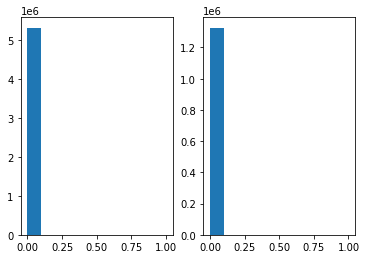

Benign


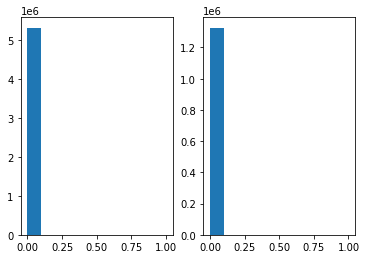

Brute Force -Web


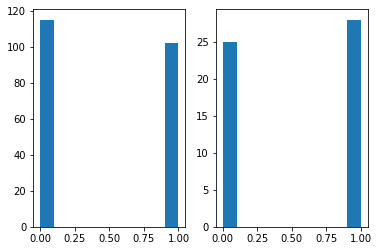

Brute Force -XSS


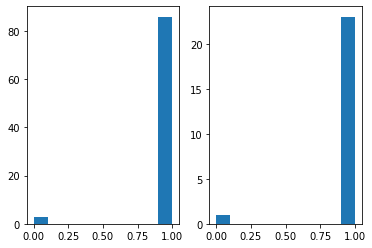

SQL Injection


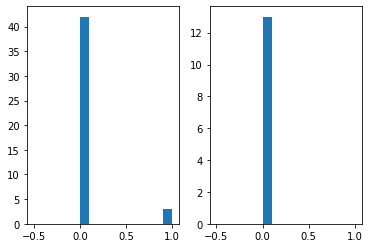

DoS attacks-Hulk


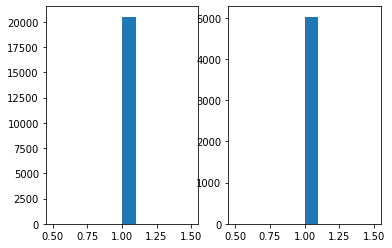

DoS attacks-GoldenEye


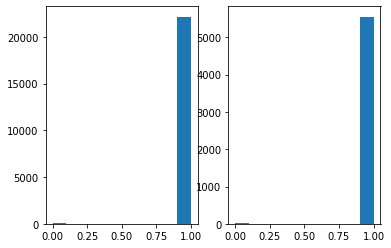

DoS attacks-Slowloris


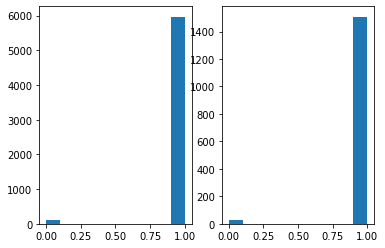

DoS attacks-SlowHTTPTest


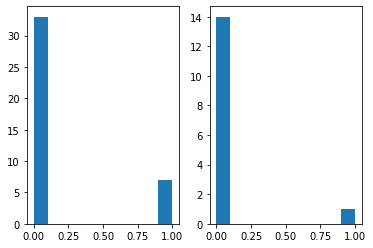

DDoS attacks-LOIC-HTTP


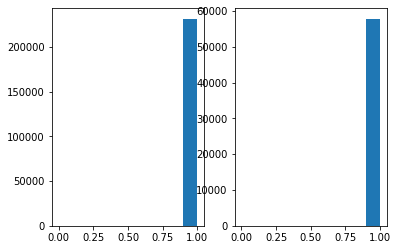

DDOS attack-HOIC


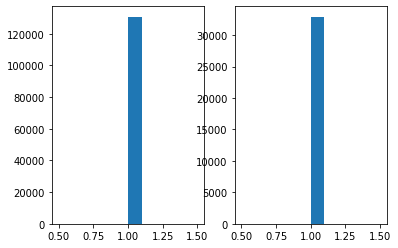

Bot


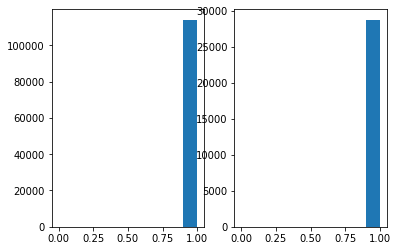

Infilteration


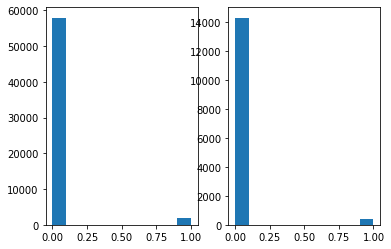

FTP-BruteForce


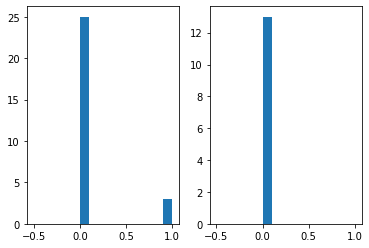

SSH-Bruteforce


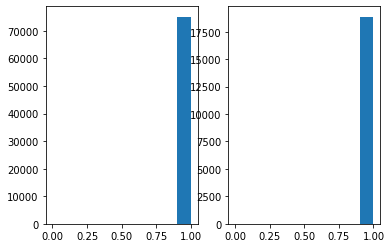

In [14]:
import matplotlib.pyplot as plt
for idx in range(len(lab_name_tot)+1):
    print((['Benign']+lab_name_tot)[idx])
    fig, ax = plt.subplots(1,2,sharex=True)
    ax[0].hist((preds['trbn'][idx]>0.5).numpy().astype(int).flatten())
    ax[1].hist((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
    plt.show()

In [15]:
lab_name

['Web_Attack', 'DoS_attacks', 'DDoS_attacks', 'Bot', 'PortScan', 'Bruteforce']

prediction results for  Benign
[0 1 2 3 4 5] [0 1 2 3 4 5]


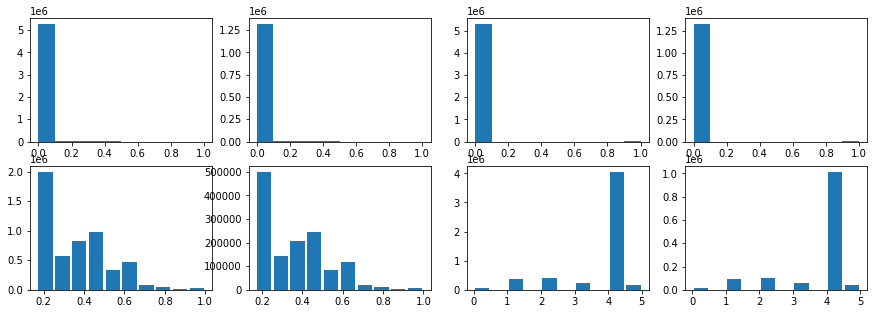

prediction results for  Benign
[0 1 2 3 4 5] [0 1 2 3 4 5]


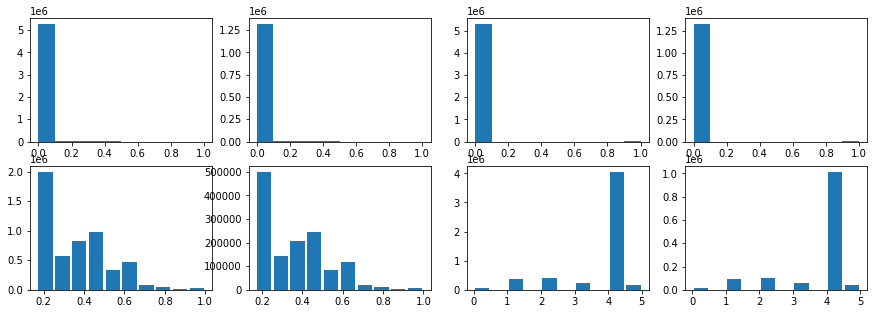

prediction results for  Brute Force -Web
[0 4 5] [0 4]


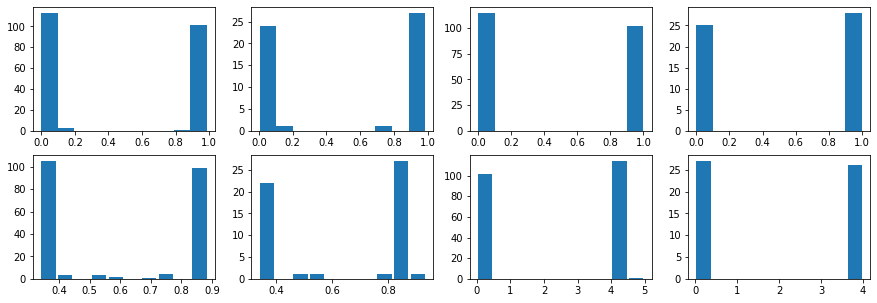

prediction results for  Brute Force -XSS
[0 2 4] [0 4]


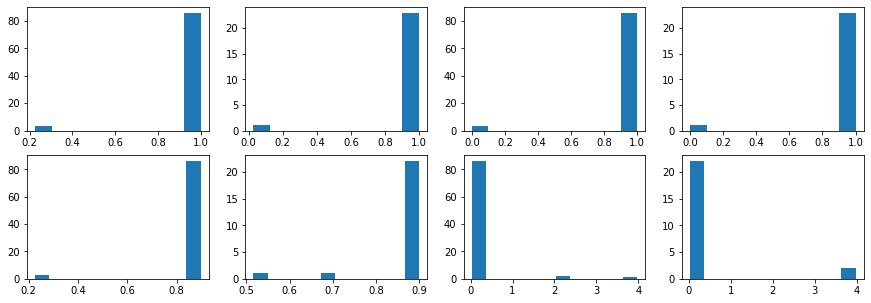

prediction results for  SQL Injection
[4 5] [2 4 5]


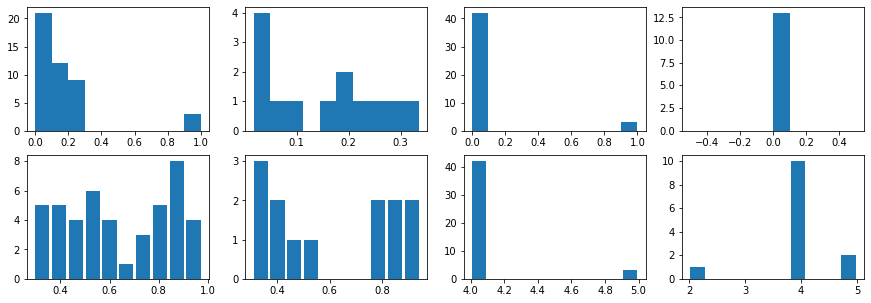

prediction results for  DoS attacks-Hulk
[1] [1]


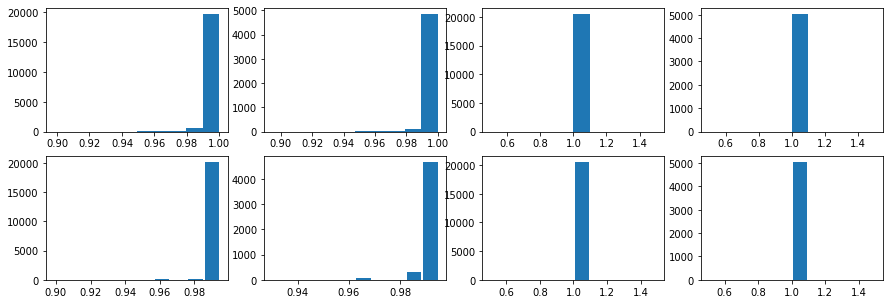

prediction results for  DoS attacks-GoldenEye
[1] [1]


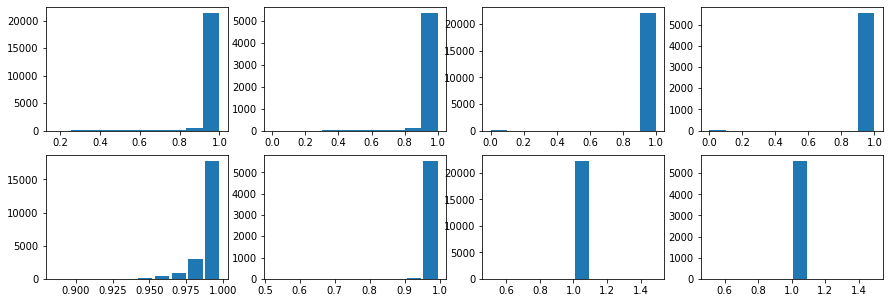

prediction results for  DoS attacks-Slowloris
[1 4] [1 5]


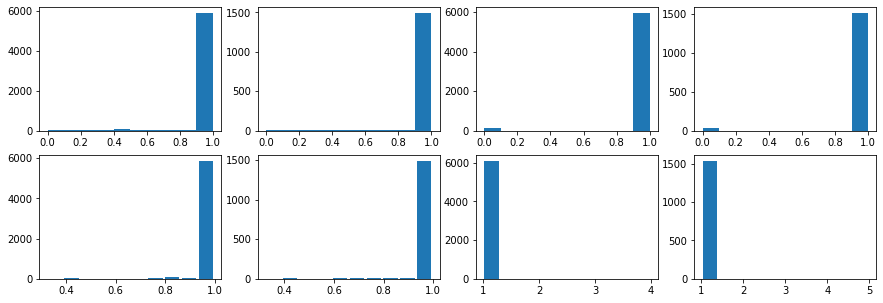

prediction results for  DoS attacks-SlowHTTPTest
[4] [4]


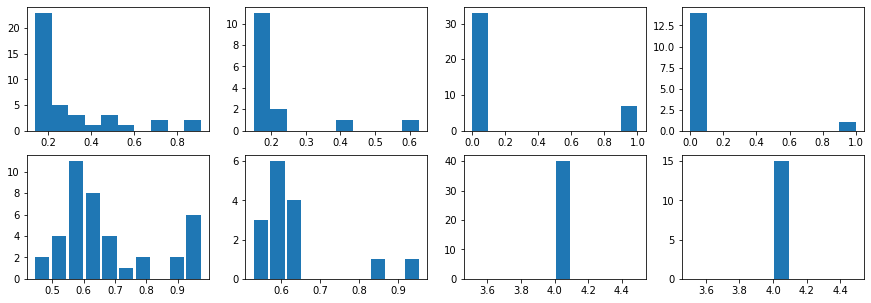

prediction results for  DDoS attacks-LOIC-HTTP
[2] [2]


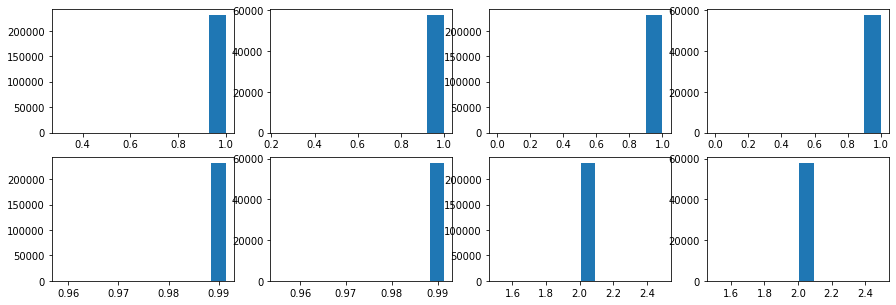

prediction results for  DDOS attack-HOIC
[2] [2]


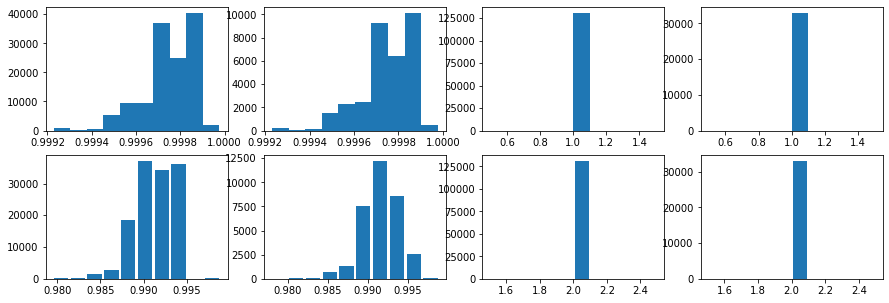

prediction results for  Bot
[1 3 4] [1 3 4]


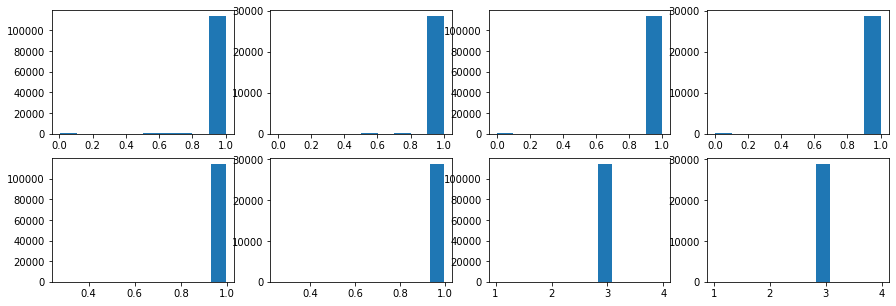

prediction results for  Infilteration
[0 1 2 3 4 5] [0 1 2 3 4 5]


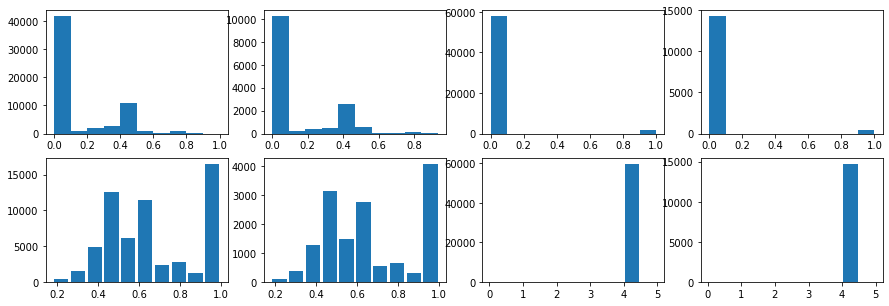

prediction results for  FTP-BruteForce
[4] [4]


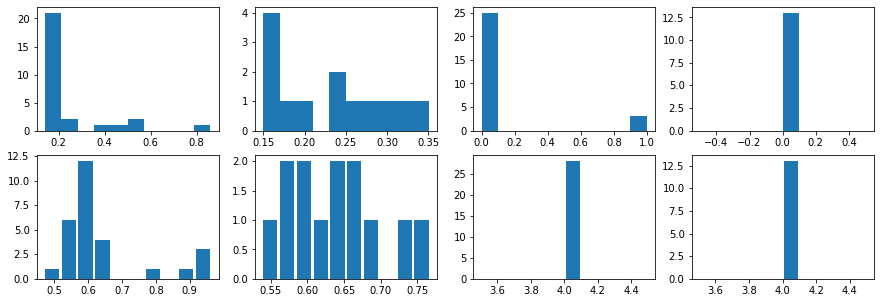

prediction results for  SSH-Bruteforce
[1 5] [5]


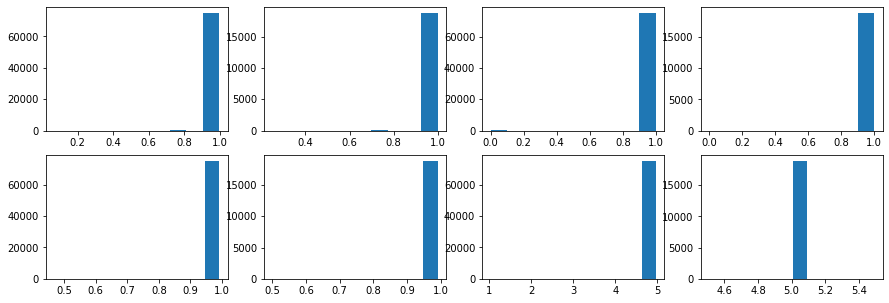

In [16]:
import matplotlib.pyplot as plt
for idx in range(len(lab_name_tot)+1):
    print('prediction results for ',(['Benign']+lab_name_tot)[idx])
    print(np.unique(torch.max(preds['trm'][idx],dim=1)[1].numpy()),np.unique(torch.max(preds['tem'][idx],dim=1)[1].numpy()))
    fig, ax = plt.subplots(2,4, figsize=(15,5))
    ax[0,0].hist((preds['trbn'][idx]).numpy().flatten())
    ax[0,1].hist((preds['tebn'][idx]).numpy().flatten())
    ax[0,2].hist((preds['trbn'][idx]>0.5).numpy().astype(int).flatten())
    ax[0,3].hist((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
    ax[1,0].hist(torch.max(preds['trm'][idx],dim=1)[0].numpy(),rwidth=0.85)
    ax[1,1].hist(torch.max(preds['tem'][idx],dim=1)[0].numpy(),rwidth=0.85)
    ax[1,2].hist(torch.max(preds['trm'][idx],dim=1)[1].numpy(),rwidth=0.85)
    ax[1,3].hist(torch.max(preds['tem'][idx],dim=1)[1].numpy(),rwidth=0.85)

    plt.show()

In [17]:
print((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
torch.max(preds['tem'][idx],dim=1)

[1 1 1 ... 1 1 1]


torch.return_types.max(
values=tensor([0.9917, 0.9911, 0.9911,  ..., 0.9929, 0.9911, 0.9916]),
indices=tensor([5, 5, 5,  ..., 5, 5, 5]))